# 1

In [2]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/EEG/DEAP/data_preprocessed_python/'
files_list = sorted(glob(FOLDER_PATH + '*'))

In [ ]:
features = []
targets = []

for i, f in (enumerate(tqdm(files_list))): 
    with open(f, 'rb') as f: 
        content = pickle.load(f, encoding='latin1')
        data = content['data']
        labels = content['labels']
        
        n_clips, n_channels, len_features = data.shape
        
        for j in range(n_clips):
            features.append(data[j])
            targets.append(labels[j])

features = np.array(features) 
targets = np.array(targets)  

100%|██████████| 32/32 [01:27<00:00,  2.73s/it]


In [ ]:
features.shape

(1280, 40, 8064)

In [ ]:
targets.shape

(1280, 4)

In [ ]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [ ]:
eeg_data = []
for i in range (len(features)):
  for j in range (len(eeg_channels)):
    eeg_data.append(features[i,j])
eeg_data = np.reshape(eeg_data, (len(features), len(eeg_channels), len(features[0,0])))
print(eeg_data.shape)

(1280, 32, 8064)


In [ ]:
#np.save('targets', targets)

In [ ]:
#np.save('features', features)

# Load npy

In [ ]:
eeg_data = np.load('/content/drive/MyDrive/EEG/DEAP/eeg_data.npy')
targets = np.load('/content/drive/MyDrive/EEG/DEAP/targets.npy')
print(eeg_data.shape)
print(targets.shape)

(1280, 32, 8064)
(1280, 4)


# CUT

In [ ]:
df_labels =  pd.DataFrame({'Valence': labels[:,0], 'Arousal': labels[:,1],'Dominance': labels[:,2] ,'Liking': labels[:,3] })
df_labels

,Valence,Arousal,Dominance,Liking
0,8.13,4.83,9.00,4.87
1,4.99,2.99,7.96,1.01
2,8.05,7.09,8.86,7.08
3,6.96,5.14,9.00,6.14
4,7.15,5.94,9.00,4.81
5,5.78,3.99,7.99,2.28
6,4.94,4.09,9.00,2.09
7,7.96,6.06,8.05,7.15
8,7.86,4.17,8.94,7.04
9,4.08,5.95,8.82,3.90


In [ ]:
!pip install mne
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore


     |████████████████████████████████| 7.4 MB 3.8 MB/s 


In [ ]:
info = mne.create_info(32, sfreq=128)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:

info = mne.create_info(eeg_channels.tolist(), ch_types=32*['eeg'], sfreq=128)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 35 items (3 Cardinal, 32 EEG)
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 128.0 Hz
>


In [ ]:
raw_data = mne.io.RawArray(eeg_data[31], info)

Creating RawArray with float64 data, n_channels=32, n_times=8064
    Range : 0 ... 8063 =      0.000 ...    62.992 secs
Ready.


Effective window size : 16.000 (s)


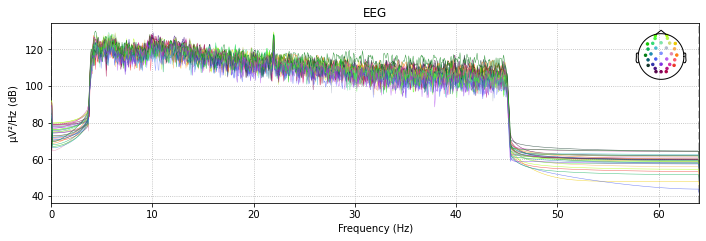

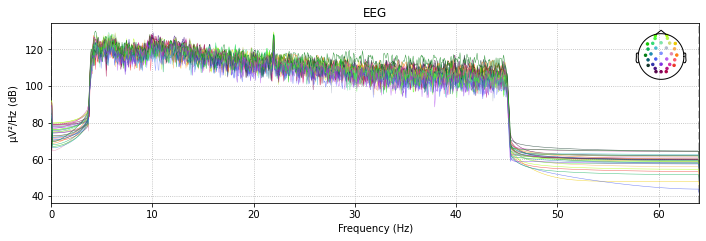

In [ ]:
mne.viz.plot_raw_psd(raw_data)

Effective window size : 10.008 (s)


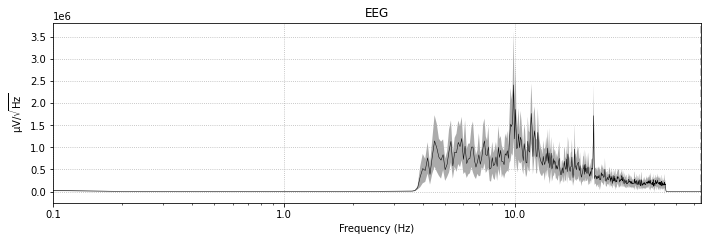

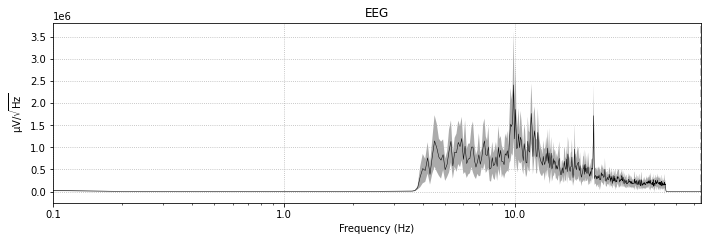

In [ ]:
raw_data.plot_psd(tmax=10., average=True, spatial_colors=False,
                 dB=False, xscale='log')

In [ ]:
eeg_data.shape

(1280, 32, 8064)

In [ ]:
e1 = eeg_data[0] # first participant - first clip.
e1.shape

(32, 8064)

In [ ]:
e1_stft = mne.time_frequency.stft(e1,256,tstep=16)

Number of frequencies: 129
Number of time steps: 504


In [ ]:
e1_stft.shape

(32, 129, 504)

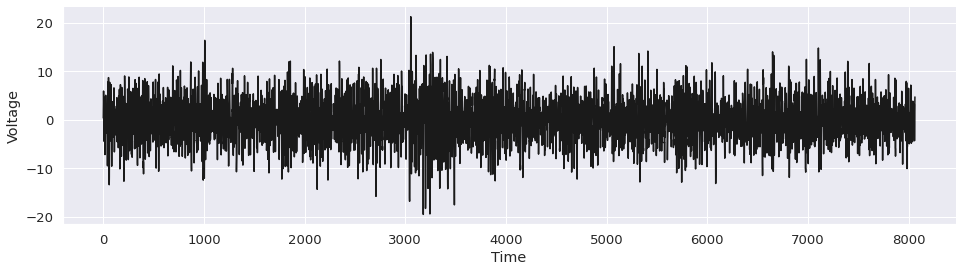

In [ ]:
sns.set(font_scale=1.2)

# Define sampling frequency and time vector
sf = 128.
time = np.arange(eeg_data.size) / sf

# Plot the signal of first trial, last channel 
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.plot(eeg_data[0,31], lw=1.5, color='k') 
plt.xlabel('Time')
plt.ylabel('Voltage')
sns.despine()


In [ ]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

In [ ]:
print(get_band_power(0,31,"theta"))
print(get_band_power(0,31,"alpha"))
print(get_band_power(0,31,"beta"))
print(get_band_power(0,31,"gamma"))

5.434119660168186
5.369595513295194
6.286556266834863
0.9879159580139809


In [ ]:
e1.shape

(32, 8064)

In [ ]:
#model hyperparameters
input_dim = len(vocab)
hidden_dim = 256
embed_dim = 300 #**<----cannot change if you are using FastText because that's the dimension of FastText
output_dim = 4
pad_idx = vocab['<pad>'] #++<----making sure our embedding layer ignores pad
num_layers = 2
bidirectional = True
dropout = 0.5

#training hyperparameters
batch_size = 64
num_epochs = 5
lr=0.0001

NameError: ignored

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #https://stackoverflow.com/questions/50856936/taking-the-last-state-from-bilstm-bigru-in-pytorch?rq=1
        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

In [ ]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [ ]:
model = LSTM()
#model.apply(initialize_weights)
#model.embedding.weight.data = fast_embedding #**<------applied the fast text embedding as the initial weights

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
                
        #predict
        predictions = 7
        
        #calculate loss
        loss = criterion(predictions, label)
        acc = binary_accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text = text.to(device) #(batch_size, seq len)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [ ]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/fasttext_BiLSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

In [ ]:
df_labels.iloc[:,0].head()

In [ ]:
features.shape

(1280, 40, 8064)

In [ ]:
targets.shape

(1280, 4)

In [ ]:
len(np.unique(targets[:,0]))

407

In [ ]:
f_p13 = eeg_data[:120,:,:]
f_p13.shape # (sample,channel,data)

(120, 32, 8064)

In [ ]:
l_p13 =targets[:120,0]
l_p13.shape

(120,)

In [ ]:
f_p45 = eeg_data[120:200,:,:]
f_p45.shape # (sample,channel,data)

(80, 32, 8064)

In [ ]:
l_p45 =targets[120:200,0]
l_p45.shape

(80,)

In [ ]:
len(np.unique(l_p13))

407

In [ ]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(l_p13)
y.shape

(120, 10)

In [ ]:
new_f_p45 =  np.empty([f_p45.shape[0],8064,32])
for i in range(f_p45.shape[0]):
  for j in range(f_p45.shape[1]):
    for k in range(f_p45.shape[2]):
      new_f_p45[i,k,j] = f_p45[i,j,k]

In [ ]:
new_f_p13 =  np.empty([120,8064,32])
for i in range(f_p13.shape[0]):
  for j in range(f_p13.shape[1]):
    for k in range(f_p13.shape[2]):
      new_f_p13[i,k,j] = f_p13[i,j,k]

In [ ]:
new_f_p13 = new_f_p13[:,:1008,:]

In [ ]:
new_f_p45 =new_f_p45[:,:504,:10]

In [ ]:
new_f_p13.shape

(120, 8064, 32)

In [ ]:
a = np.arange(18).reshape((3, 2,3))
a

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]],

       [[12, 13, 14],
        [15, 16, 17]]])

In [ ]:
print(a[0,0,2])

2


In [ ]:
newa = np.empty([3,3,2])
for i in range(a.shape[0]):
  for j in range(a.shape[1]):
    for k in range(a.shape[2]):
      newa[i,k,j] = a[i,j,k]

In [ ]:
newa

NameError: ignored

# Keras 

In [ ]:
import keras
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM,BatchNormalization,Activation
model = Sequential()
model.add(LSTM(512, batch_input_shape = (None, None, x_train.shape[2]),return_sequences=True))
#model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(256,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(LSTM(128,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(64,activation="relu",return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(LSTM(32,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(10))
model.add(Activation('sigmoid'))

rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-08)
model.compile(loss='mean_squared_error', optimizer=rmsprop,metrics=['accuracy'])
#adam = Adam(lr=0.5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 512)         1312768   
                                                                 
 batch_normalization (BatchN  (None, None, 512)        2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         787456    
                                                                 
 batch_normalization_1 (Batc  (None, None, 256)        1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(x_train, y_train, epochs = 100, batch_size=20,validation_data= (x_val, y_val))

Epoch 1/100
45/45 [==============================] - 2s 44ms/step - loss: 0.2732 - accuracy: 0.1138 - val_loss: 0.1922 - val_accuracy: 0.0234
Epoch 2/100
45/45 [==============================] - 2s 44ms/step - loss: 0.2672 - accuracy: 0.1038 - val_loss: 0.1883 - val_accuracy: 0.0234
Epoch 3/100
45/45 [==============================] - 2s 44ms/step - loss: 0.2661 - accuracy: 0.1161 - val_loss: 0.1912 - val_accuracy: 0.0547
Epoch 4/100
45/45 [==============================] - 2s 45ms/step - loss: 0.2631 - accuracy: 0.1116 - val_loss: 0.1971 - val_accuracy: 0.0859
Epoch 5/100
45/45 [==============================] - 2s 45ms/step - loss: 0.2557 - accuracy: 0.1105 - val_loss: 0.1972 - val_accuracy: 0.1016
Epoch 6/100
45/45 [==============================] - 2s 45ms/step - loss: 0.2496 - accuracy: 0.1183 - val_loss: 0.2045 - val_accuracy: 0.1250
Epoch 7/100
45/45 [==============================] - 2s 44ms/step - loss: 0.2507 - accuracy: 0.0982 - val_loss: 0.2096 - val_accuracy: 0.0938
Epoch 

# Band_power extract

In [ ]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway
def bandpower(data, sf, band, window_sec=None, relative=False):
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

# New Section

In [ ]:
def get_band_power(trial, channel, band):
  bd = (0,0)

  if (band == "theta"): # drownsiness, emotional connection, intuition, creativity
    bd = (4,8)
  elif (band == "alpha"): # reflection, relaxation
    bd = (8,12)
  elif (band == "beta"): # concentration, problem solving, memory
    bd = (12,30)
  elif (band == "gamma"): # cognition, perception, learning, multi-tasking
    bd = (30,64)
  
  return bandpower(eeg_data[trial,channel], 128, bd)

In [ ]:
# Transform 1280 x 32 x 8064 => 1280 x 128
eeg_band_arr = []
for i in range (len(eeg_data)):
  for j in range (len(eeg_data[0])):
    eeg_band_arr.append(get_band_power(i,j,"theta"))
    eeg_band_arr.append(get_band_power(i,j,"alpha"))
    eeg_band_arr.append(get_band_power(i,j,"beta"))
    eeg_band_arr.append(get_band_power(i,j,"gamma"))
#eeg_band_arr = np.reshape(eeg_band_arr, (1280, 128))

In [ ]:
eeg_band_arr = np.reshape(eeg_band_arr, (eeg_data.shape[0],eeg_data.shape[1]*4))
eeg_band_arr.shape

(1280, 128)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(eeg_band_arr)
norm_eeg_band_arr = scaler.transform(eeg_band_arr)

In [ ]:
norm_eeg_band_arr1 = np.reshape(norm_eeg_band_arr, (norm_eeg_band_arr.shape[0],1,norm_eeg_band_arr.shape[1]))

In [ ]:
targets.shape

(1280, 4)

# Valence

In [ ]:
# valence 0-low ,1 high 
valence = []
mean_valence = np.median(targets[:,0])
for i in range(targets.shape[0]):
  if targets[i,0] < mean_valence :
    valence.append(0)
  else :
    valence.append(1)
valence = np.array(valence)
valence.shape

(1280,)

In [ ]:
valence = valence.reshape(-1,1)
valence.shape

(1280, 1)

In [ ]:
"""from tensorflow.keras.utils import to_categorical
valence = to_categorical(valence)
valence.shape"""

'from tensorflow.keras.utils import to_categorical\nvalence = to_categorical(valence)\nvalence.shape'

In [ ]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,features.shape[0],1)
np.random.shuffle(idx)
ts = int(train_size*features.shape[0]) 
vs = int(val_size*features.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [ ]:
x_train = norm_eeg_band_arr1[idx_train]
x_val = norm_eeg_band_arr1[idx_val]
x_test = norm_eeg_band_arr1[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)


print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (896, 1, 128)
x_val (128, 1, 128)
x_test (256, 1, 128)
y_train (896, 1)
y_val (128, 1)
y_test (256, 1)


In [ ]:
import torch

x_train = (torch.from_numpy(x_train)).double()
x_val = (torch.from_numpy(x_val)).double()
x_test = (torch.from_numpy(x_test)).double()

y_train = (torch.from_numpy(y_train)).double()
y_val = (torch.from_numpy(y_val)).double()
y_test = (torch.from_numpy(y_test)).double()

# Valence Cat

In [ ]:
from tensorflow.keras.utils import to_categorical
valence = to_categorical(targets[:,0])
valence.shape

(1280, 10)

In [ ]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,features.shape[0],1)
np.random.shuffle(idx)
ts = int(train_size*features.shape[0]) 
vs = int(val_size*features.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [ ]:
x_train = norm_eeg_band_arr1[idx_train]
x_val = norm_eeg_band_arr1[idx_val]
x_test = norm_eeg_band_arr1[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)


print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (896, 1, 128)
x_val (128, 1, 128)
x_test (256, 1, 128)
y_train (896, 10)
y_val (128, 10)
y_test (256, 10)


In [ ]:
import torch

x_train = (torch.from_numpy(x_train)).double()
x_val = (torch.from_numpy(x_val)).double()
x_test = (torch.from_numpy(x_test)).double()

y_train = (torch.from_numpy(y_train)).double()
y_val = (torch.from_numpy(y_val)).double()
y_test = (torch.from_numpy(y_test)).double()

# Arousal

In [ ]:
# arousal 0-low ,1 high 
arousal = []
mean_arousal = np.median(targets[:,1])
for i in range(targets.shape[0]):
  if targets[i,0] < mean_arousal :
    arousal.append(0)
  else :
    arousal.append(1)
arousal = np.array(arousal)
arousal.shape

(1280,)

In [ ]:
arousal = arousal.reshape(-1,1)
arousal.shape

(1280, 1)

In [ ]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,features.shape[0],1)
np.random.shuffle(idx)
ts = int(train_size*features.shape[0]) 
vs = int(val_size*features.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [ ]:
x_train = norm_eeg_band_arr1[idx_train]
x_val = norm_eeg_band_arr1[idx_val]
x_test = norm_eeg_band_arr1[idx_test]

y_train = arousal[idx_train]
y_val = arousal[idx_val]
y_test = arousal[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)


print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (896, 1, 128)
x_val (128, 1, 128)
x_test (256, 1, 128)
y_train (896, 1)
y_val (128, 1)
y_test (256, 1)


In [ ]:
import torch

x_train = (torch.from_numpy(x_train)).double()
x_val = (torch.from_numpy(x_val)).double()
x_test = (torch.from_numpy(x_test)).double()

y_train = (torch.from_numpy(y_train)).double()
y_val = (torch.from_numpy(y_val)).double()
y_test = (torch.from_numpy(y_test)).double()

# Valence & Arousal


In [ ]:
# arousal 0-low ,1 high 
arousal = []
mean_arousal = np.median(targets[:,1])
for i in range(targets.shape[0]):
  if targets[i,0] < mean_arousal :
    arousal.append(0)
  else :
    arousal.append(1)
arousal = np.array(arousal)
arousal.shape

(1280,)

In [ ]:
# valence 0-low ,1 high 
valence = []
mean_valence = np.median(targets[:,0])
for i in range(targets.shape[0]):
  if targets[i,0] < mean_valence :
    valence.append(0)
  else :
    valence.append(1)
valence = np.array(valence)
valence.shape

(1280,)

In [ ]:
arousal_valence = np.concatenate((arousal.reshape(-1,1),valence.reshape(-1,1)),axis=1)
arousal_valence.shape

(1280, 2)

In [ ]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,features.shape[0],1)
np.random.shuffle(idx)
ts = int(train_size*features.shape[0]) 
vs = int(val_size*features.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [ ]:
x_train = norm_eeg_band_arr1[idx_train]
x_val = norm_eeg_band_arr1[idx_val]
x_test = norm_eeg_band_arr1[idx_test]

y_train = arousal_valence[idx_train]
y_val = arousal_valence[idx_val]
y_test = arousal_valence[idx_test]
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)


print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (896, 1, 128)
x_val (128, 1, 128)
x_test (256, 1, 128)
y_train (896, 2)
y_val (128, 2)
y_test (256, 2)


In [ ]:
import torch

x_train = (torch.from_numpy(x_train)).double()
x_val = (torch.from_numpy(x_val)).double()
x_test = (torch.from_numpy(x_test)).double()

y_train = (torch.from_numpy(y_train)).double()
y_val = (torch.from_numpy(y_val)).double()
y_test = (torch.from_numpy(y_test)).double()

# Pytorch LSTM1

In [ ]:
#model hyperparameters
hidden_dim = 16
#hd2=hidden_dim/2
embed_dim = x_train.shape[2]
#ed2 = hidden_dim*2
output_dim = y_train.shape[1]
num_layers = 1
bidirectional = True
dropout = 0.5

#training hyperparameters
batch_size = 16
num_epochs = 100
lr=0.0001

In [ ]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #self.b_norm = nn.BatchNorm1d(hidden_dim*2).double()
        self.layernorm = nn.LayerNorm(hidden_dim*2).double()
        self.relu = nn.ELU()
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        
    def forward(self, x):
        out,(hn, cn) = self.lstm(x)


        hn = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim = 1)
        #hn = self.b_norm(hn)
        hn = self.layernorm(hn)
        return self.fc(self.relu(hn))

# Try shape

In [ ]:
m= nn.LSTM(embed_dim,hidden_dim, num_layers=num_layers,bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True).double()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
z,(a,b) = m(x_train)

In [ ]:
x_train.shape

torch.Size([896, 1, 128])

In [ ]:
z.size()

torch.Size([896, 1, 32])

In [ ]:
a.size()

torch.Size([2, 896, 16])

In [ ]:
m2= nn.LSTM(32,5, num_layers=num_layers,bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True).double()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
z2,(a2,b2) = m2(z)

In [ ]:
z2.size()

torch.Size([896, 1, 10])

In [ ]:
a2.size()

torch.Size([2, 896, 5])

In [ ]:
an = torch.cat((a[-2,:,:], a[-1,:,:]), dim = 1)

In [ ]:
an.size()

torch.Size([896, 32])

In [ ]:
bnorm = nn.BatchNorm1d(64).double()

In [ ]:
qq = bnorm(z)

RuntimeError: ignored

In [ ]:
qq.size()

torch.Size([896, 64])

In [ ]:
m2 = nn.Linear(hidden_dim * 2, output_dim)

In [ ]:
a2 = m2(an.float())

In [ ]:
a2.size()

torch.Size([1000, 1])

In [ ]:
a2.squeeze(1).size()

torch.Size([1000])

# try 2 

In [ ]:
model = LSTM().double()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
y_train.shape

torch.Size([896, 10])

In [ ]:
v = model(x_train)
predictions.size()

torch.Size([896, 10])

In [ ]:
pred1 = predictions.max(1).indices
print(pred1.size())


torch.Size([896])


In [ ]:
  acc = (pred1 == y_train.max(1).indices).sum() / pred1.size(0)

In [ ]:
abc = (pred1 == y_train.max(1).indices)

In [ ]:
abc.sum()

tensor(133)

In [ ]:
loss = criterion(predictions, y_train.double())
acc = binary_accuracy(predictions, y_train)

In [ ]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
predictions = model(new_f_p13)
print(predictions.size())
#calculate loss
loss = criterion(predictions, l_p13)
acc = binary_accuracy(predictions, l_p13)

#backprop
optimizer.zero_grad()
loss.backward()
optimizer.step()

NameError: ignored

# Predict


In [ ]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here

In [ ]:
model = LSTM()
model.apply(initialize_weights)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


LSTM(
  (lstm): LSTM(128, 16, batch_first=True, dropout=0.5, bidirectional=True)
  (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (relu): ELU(alpha=1.0)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=lr) #<----changed to Adam
#optimizer = optim.RMSprop(model.parameters(), lr=lr)

criterion = nn.BCEWithLogitsLoss() #combine sigmoid with binary cross entropy
#criterion = nn.CrossEntropyLoss()
#criterion = nn.MSELoss()

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def multi_accuracy(pred,y):
  pred1 = pred.max(1).indices
  #print(pred1)
  acc = (pred1 == y.max(1).indices).sum() / pred1.size(0)
  #print(acc)
  return acc

In [ ]:
def train(model, x,y, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i in range(1,num_epochs+1): 

        #predict
        predictions = model(x)
        #calculate loss
        loss = criterion(predictions, y)
        acc = binary_accuracy(predictions, y)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / num_epochs, epoch_acc / num_epochs

In [ ]:
def evaluate(model, x,y, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i in range(1,num_epochs+1): 
            #label = label.to(device) #(batch_size, )
            #text = text.to(device) #(batch_size, seq len)

            predictions = model(x)
            
            loss = criterion(predictions, y)
            acc = binary_accuracy(predictions, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / num_epochs, epoch_acc / num_epochs

In [ ]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(num_epochs):

    train_loss, train_acc = train(model.double(), x_train,y_train, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model.double(), x_val,y_val, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'models/fasttext_BiLSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.741 | Train Acc: 53.64%
	 Val. Loss: 0.706 |  Val. Acc: 54.69%
Epoch: 02 | Train Loss: 0.673 | Train Acc: 57.33%
	 Val. Loss: 0.676 |  Val. Acc: 58.59%
Epoch: 03 | Train Loss: 0.649 | Train Acc: 60.91%
	 Val. Loss: 0.660 |  Val. Acc: 60.16%
Epoch: 04 | Train Loss: 0.634 | Train Acc: 62.53%
	 Val. Loss: 0.647 |  Val. Acc: 60.94%
Epoch: 05 | Train Loss: 0.622 | Train Acc: 63.48%
	 Val. Loss: 0.636 |  Val. Acc: 63.28%
Epoch: 06 | Train Loss: 0.611 | Train Acc: 64.76%
	 Val. Loss: 0.626 |  Val. Acc: 65.62%
Epoch: 07 | Train Loss: 0.600 | Train Acc: 66.40%
	 Val. Loss: 0.616 |  Val. Acc: 64.06%
Epoch: 08 | Train Loss: 0.589 | Train Acc: 68.17%
	 Val. Loss: 0.608 |  Val. Acc: 66.41%
Epoch: 09 | Train Loss: 0.578 | Train Acc: 69.28%
	 Val. Loss: 0.602 |  Val. Acc: 67.97%
Epoch: 10 | Train Loss: 0.567 | Train Acc: 70.66%
	 Val. Loss: 0.601 |  Val. Acc: 67.97%
Epoch: 11 | Train Loss: 0.556 | Train Acc: 71.07%
	 Val. Loss: 0.601 |  Val. Acc: 64.84%
Epoch: 12 | Train Los

Text(0, 0.5, 'loss')

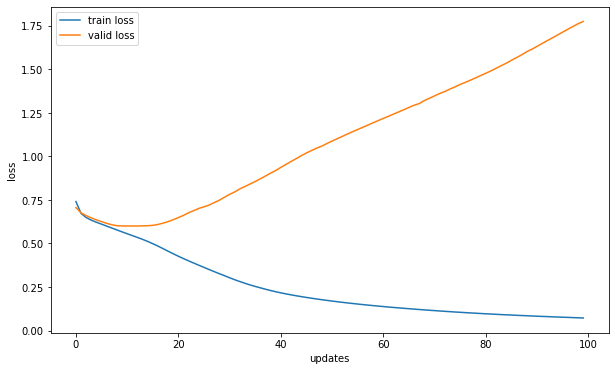

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')


Text(0, 0.5, 'acc')

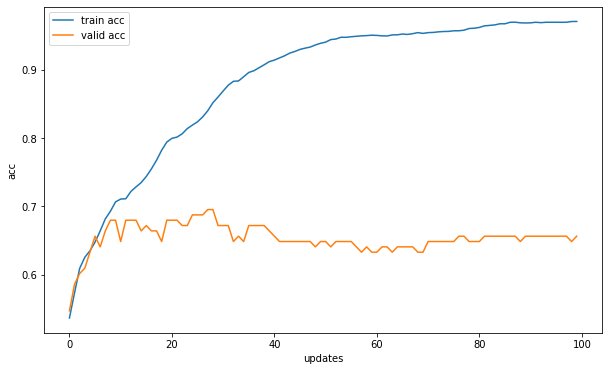

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [ ]:
test_loss, test_acc = evaluate(model.double(),  x_test,y_test, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 2.042 | Test Acc: 59.38%


*italicized text*# New Section

# stft

In [ ]:
 
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

     |████████████████████████████████| 7.4 MB 15.5 MB/s 


In [ ]:
stft_data = np.zeros([1280,32,129,63])

for i in range(stft_data.shape[0]):
  xx = mne.time_frequency.stft(eeg_data[i],wsize=256)
  stft_data[i] = xx

Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of frequencies: 129
Number of time steps: 63
Number of fr

In [ ]:
stft_data.shape

(1280, 32, 129, 63)

In [ ]:
np.save('stft_data',stft_data)

# stft download

In [1]:
import torch, torchvision
from torchvision import transforms
from torch import nn
import numpy as np
import sys

In [4]:
stft_data = np.load('/content/drive/MyDrive/EEG/DEAP/stft_data.npy')
targets = np.load('/content/drive/MyDrive/EEG/DEAP/targets.npy')

In [35]:
# valence 0-low ,1 high 
valence = []
mean_valence = np.median(targets[:,0])
for i in range(targets.shape[0]):
  if targets[i,0] < mean_valence :
    valence.append(0)
  else :
    valence.append(1)
valence = np.array(valence)
valence.shape

(1280,)

In [10]:
valence = np.round(targets[:,0])
valence.shape

(1280,)

In [5]:
eeg_channels = np.array(["Fp1", "AF3", "F3", "F7", "FC5", "FC1", "C3", "T7", "CP5", "CP1", "P3", "P7", "PO3", "O1", "Oz", "Pz", "Fp2", "AF4", "Fz", "F4", "F8", "FC6", "FC2", "Cz", "C4", "T8", "CP6", "CP2", "P4", "P8", "PO4", "O2"])
peripheral_channels = np.array(["hEOG", "vEOG", "zEMG", "tEMG", "GSR", "Respiration belt", "Plethysmograph", "Temperature"])

In [6]:
eeg_channel = eeg_channels.tolist()

In [7]:
frontal_lobes = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4', 'P3', 'P4']

In [8]:
fl_chan = []
for chan in  frontal_lobes:
  if chan in eeg_channel:
    fl_chan.append(eeg_channel.index(chan))
fl_chan

[1, 3, 2, 4, 7, 11, 13, 31, 29, 25, 21, 19, 20, 17, 10, 28]

In [ ]:
len(fl_chan)

16

In [9]:
stft_data = stft_data[:,fl_chan,:,:]
stft_data.shape

(1280, 16, 129, 63)

# split

In [ ]:
#valence = valence.reshape(-1,1)
#valence.shape 

In [36]:
train_size = 0.7
val_size = 0.1
idx = np.arange(0,stft_data.shape[0],1)
np.random.shuffle(idx)
ts = int(train_size*stft_data.shape[0]) 
vs = int(val_size*stft_data.shape[0]) 
idx_train = idx[0:ts]
idx_val = idx[ts:ts+vs]
idx_test = idx[ts+vs:]

In [37]:
x_train = stft_data[idx_train]
x_val =  stft_data[idx_val]
x_test = stft_data[idx_test]

y_train = valence[idx_train]
y_val = valence[idx_val]
y_test = valence[idx_test]

In [38]:
print('x_train',x_train.shape)
print('x_val',x_val.shape)
print('x_test',x_test.shape)

print('y_train',y_train.shape)
print('y_val',y_val.shape)
print('y_test',y_test.shape)

x_train (896, 16, 129, 63)
x_val (128, 16, 129, 63)
x_test (256, 16, 129, 63)
y_train (896,)
y_val (128,)
y_test (256,)


In [39]:
len(np.unique(y_test))

2

In [40]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

batch_size = 50
def dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

train_loader = dataloader(x_train, y_train, batch_size)

valid_loader = dataloader(x_val, y_val, batch_size)

test_loader = dataloader(x_test, y_test, batch_size)

In [51]:
#Number of frequencies: 129
#Number of time steps: 63
xp = x_train[0]

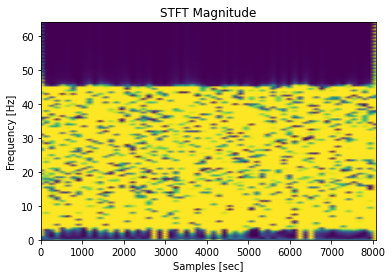

In [71]:
xp[0].shape
from scipy import signal
plt.pcolormesh(np.linspace(0, 8064 , num= xp.shape[2]),
               np.linspace(0, 64 , num= xp.shape[1]),
               np.abs(xp[0])
               ,vmin=0, 
               vmax=4, 
               shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples [sec]')
plt.show()

In [72]:
df = pd.DataFrame(xp[15])
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,0.807921,-0.567317,-0.856562,-1.206074,-0.959972,-1.081819,-0.950042,-0.998347,-0.922021,-1.144564,-0.990446,-1.157285,-1.037989,-1.130009,-1.129227,-1.194702,-1.048509,-1.001712,-0.788971,-0.917822,-0.835688,0.343187,-0.898504,0.391555,-0.958318,-0.679499,-1.502728,-0.848980,-1.365402,-0.785066,-0.924780,-1.640685,-0.962676,-1.612341,-0.794934,-0.417906,-0.659328,-0.535880,-0.693283,-0.888014,-0.811035,-1.009808,-0.667631,-0.978760,-0.639215,-0.785266,-0.655482,-0.862193,0.506560,-0.828399,0.392436,-0.747964,-0.719444,-0.844061,-0.760815,-0.889567,-0.884848,-0.992003,-0.885659,-0.858138,-0.811935,-1.005266,9.102281
1,-0.177178,0.559151,0.261502,-0.102378,0.157060,0.029644,0.168106,0.116075,0.195225,-0.034750,0.124635,-0.048583,0.075058,-0.025940,-0.017652,-0.092529,0.066705,0.110490,0.332678,0.197364,0.285636,1.507927,0.223233,1.558852,0.159160,0.445065,-0.412786,0.269195,-0.270003,0.337951,0.190369,-0.544595,0.151494,-0.515499,0.326452,0.729056,0.470343,0.606899,0.436039,0.230497,0.311369,0.101499,0.455467,0.131814,0.481024,0.334881,0.468241,0.258750,1.675964,0.295387,1.558131,0.375944,0.406009,0.275279,0.361960,0.229334,0.231178,0.121586,0.229584,0.259069,0.307773,0.105563,1.423516
2,-1.488809,0.352392,0.027553,-0.383195,-0.079268,-0.223838,-0.063275,-0.127829,-0.039661,-0.294558,-0.118736,-0.312355,-0.174708,-0.305291,-0.271379,-0.378877,-0.176146,-0.143321,0.111284,-0.044584,0.065016,1.429210,0.003262,1.486930,-0.075795,0.232553,-0.739086,0.035411,-0.577102,0.121671,-0.051419,-0.847346,-0.094708,-0.817107,0.104153,0.591573,0.274563,0.455875,0.240280,-0.000571,0.094318,-0.153187,0.238956,-0.126460,0.253405,0.108701,0.252858,0.035667,1.610489,0.081194,1.480909,0.162727,0.197450,0.046296,0.144322,-0.000649,-0.008126,-0.124930,-0.013477,0.023207,0.079100,-0.152553,-10.138002
3,1.769985,0.348512,-0.027494,-0.531638,-0.135548,-0.314000,-0.109531,-0.199715,-0.094288,-0.397341,-0.189682,-0.423167,-0.258855,-0.452607,-0.363673,-0.541300,-0.246733,-0.238447,0.081576,-0.114898,0.040364,1.688062,-0.014146,1.759991,-0.125862,0.220788,-0.981747,-0.019609,-0.781212,0.105010,-0.120337,-1.034251,-0.173103,-1.001750,0.075030,0.739154,0.304006,0.576294,0.269050,-0.046765,0.076041,-0.249220,0.215455,-0.231047,0.205510,0.070276,0.236760,0.007022,1.893890,0.073286,1.740486,0.153307,0.195397,0.002381,0.122886,-0.044940,-0.073247,-0.203116,-0.086754,-0.035730,0.035607,-0.256890,-3.405456
4,2.118668,0.369257,-0.092584,-0.770623,-0.192120,-0.432166,-0.146545,-0.286431,-0.151079,-0.540248,-0.276284,-0.580862,-0.370636,-0.694561,-0.492183,-0.816208,-0.336270,-0.380890,0.065091,-0.205510,0.045580,2.225316,0.021325,2.325418,-0.158991,0.237851,-1.407798,-0.087849,-1.133888,0.120903,-0.204794,-1.329341,-0.279331,-1.293511,0.068147,1.085151,0.424076,0.871288,0.385023,-0.084323,0.090790,-0.389527,0.199800,-0.392258,0.137261,0.041606,0.251545,0.007780,2.470784,0.119763,2.271372,0.187978,0.237541,-0.037444,0.124461,-0.080868,-0.154133,-0.304770,-0.186471,-0.108223,-0.005898,-0.418262,11.524860


In [73]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,0.000844,-0.018258,-0.003407,0.001232,-0.005576,-0.002967,0.000998,0.007039,-0.000521,-0.005840,-0.002672,0.010834,0.000786,-0.008791,-0.004378,0.001099,0.004497,-0.003018,-0.004180,0.000748,-0.004037,-0.000162,-0.000574,-0.023889,-0.001468,-0.006341,-0.003743,-0.017769,-0.004981,-0.003720,-0.005810,-0.010542,0.001353,0.031866,-0.007151,-0.003358,-0.009712,-0.007311,-0.006073,-0.000220,-0.001315,-0.002600,0.000481,0.000862,-0.009835,-0.005863,-0.005811,-0.006190,-0.000798,0.009153,-0.027101,-0.004070,-0.005377,-0.002213,-0.002796,-0.006544,-0.001753,-0.004930,-0.005505,-0.001647,-0.003945,-0.006810,0.025295
std,23.865581,22.262373,19.745443,4.293167,5.315720,3.893946,8.062504,3.890089,5.646873,8.711028,11.943623,5.968276,4.103379,4.244813,20.780311,17.107924,7.199234,7.012543,11.893932,9.567490,3.663875,6.791006,28.194376,9.498939,3.880017,5.461209,14.976524,27.621690,6.287017,4.200235,7.310910,7.814231,20.425369,4.977592,10.906229,8.546440,18.343942,8.605659,5.876107,4.594894,5.802179,5.721806,10.333197,20.430707,6.146545,7.345377,6.080737,4.635136,11.114837,34.349135,4.697156,3.789604,6.072818,7.227318,7.023192,6.427419,6.484309,7.277071,8.413613,5.875250,7.493915,4.313331,11.358242
min,-161.983162,-136.782159,-120.462046,-12.038293,-21.046213,-15.972294,-42.456543,-12.283559,-19.533893,-48.321765,-61.586686,-15.448162,-11.833109,-10.141156,-123.481146,-136.530901,-37.443101,-41.123734,-62.715395,-43.090613,-13.186125,-55.526239,-149.056060,-48.595094,-11.709333,-23.486251,-58.149076,-177.003524,-22.996426,-10.422456,-23.895768,-32.629965,-112.434865,-12.014674,-52.688245,-51.045178,-98.226743,-70.472240,-24.913633,-14.540823,-27.792171,-17.814138,-57.531171,-115.845718,-24.295399,-32.801724,-24.886031,-17.402386,-54.378318,-220.356586,-30.705547,-10.127220,-27.445449,-33.850588,-43.106474,-19.624612,-29.264436,-29.767155,-28.074944,-19.761125,-29.523706,-13.729152,-50.207924
25%,-1.488809,-1.483754,-1.509877,-1.341963,-2.016303,-1.393632,-1.473756,-1.647362,-2.471019,-2.374121,-1.297133,-2.330990,-1.161127,-1.646406,-2.247214,-1.416015,-1.675737,-1.001712,-1.666782,-1.195349,-1.229002,-0.734066,-0.898504,-2.019200,-1.661717,-1.651978,-3.180855,-2.249385,-1.882808,-1.534506,-1.560130,-1.982556,-2.530751,-1.946604,-1.772771,-1.442793,-1.939295,-1.211008,-0.786962,-1.274909,-2.034596,-1.288241,-1.372839,-1.998467,-1.812453,-1.295861,-1.406423,-1.456143,-1.756616,-2.942962,-1.290549,-1.320845,-1.803691,-1.871528,-2.190399,-2.267191,-2.658326,-1.928291,-1.982859,-1.289842,-2.042318,-1.453840,-2.600670
50%,0.001104,0.006300,-0.000225,0.002995,-0.004986,-0.008096,-0.000046,-0.004963,0.006833,-0.012665,0.007875,-0.016338,0.001019,-0.007803,0.003072,-0.009513,0.002650,-0.003898,-0.007459,-0.000499,-0.004921,0.001392,0.001108,-0.001473,-0.005382,0.014879,0.005120,0.016408,0.007753,0.009002,-0.004208,0.003536,0.000511,-0.002898,0.010736,0.001074,0.011490,0.005511,0.005810,0.001767,-0.001705,-0.006368,-0.002166,-0.020103,0.002276,-0.009884,-0.000306,-0.010850,0.000505,-0.009550,0.007080,-0.000382,0.007056,0.001509,0.000099,0.000826,-0.003496,-0.000772,0.002766,-0.00126

# try shape conv

In [ ]:
layer1 = nn.Sequential(
            #in_channel = 1
            #out_channel = 16
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)).double()

In [ ]:
 fc1 = nn.Linear(32*32*15, 2).double()

In [ ]:
a1 = layer1(x_train[:10]).double()
a1.shape

torch.Size([10, 64, 64, 31])

In [ ]:
a1_reshape =  a1.reshape(a1.size(0), -1)
a1_reshape.shape

torch.Size([10, 31744])

In [ ]:
l2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)).double()


In [ ]:
a2 = l2(a1)
a2.shape

torch.Size([10, 128, 32, 15])

In [ ]:
a2_reshape =  a2.reshape(a2.size(0), -1)
a2_reshape.shape

torch.Size([10, 61440])

In [ ]:
f1 = fc1(a2_reshape)
f1.shape

torch.Size([10, 2])

# Conv2d model

In [42]:
num_epochs = 10
num_classes = 2
learning_rate = 0.001

In [43]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(stft_data.shape[1], 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(128*16*7, num_classes)
        self.drop_out = nn.Dropout(p=0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        out = self.drop_out(out)

        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [44]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [45]:
model = ConvNet(num_classes)
model.apply(initialize_weights)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=14336, out_features=2, bias=True)
  (drop_out): Dropout(p=0.5, inplace=False)
)

In [46]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# New Section

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [24]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    correct = (predicted == y).sum()
    acc = correct / y.size(0)
    return acc

In [25]:
def train(model, loader, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    for i, (features, label) in enumerate(loader): 
                
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [26]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader): 


            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [47]:
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss,valid_acc = evaluate(model, valid_loader, criterion)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Train Loss: 1.607 | Train Acc: 51.82%
	 Val. Loss: 0.903 |  Val. Acc: 58.62%
Epoch: 02 | Train Loss: 1.186 | Train Acc: 52.76%
	 Val. Loss: 0.829 |  Val. Acc: 56.24%
Epoch: 03 | Train Loss: 1.162 | Train Acc: 53.58%
	 Val. Loss: 0.779 |  Val. Acc: 57.86%
Epoch: 04 | Train Loss: 1.213 | Train Acc: 54.37%
	 Val. Loss: 1.194 |  Val. Acc: 55.71%
Epoch: 05 | Train Loss: 1.235 | Train Acc: 53.08%
	 Val. Loss: 0.854 |  Val. Acc: 55.86%
Epoch: 06 | Train Loss: 1.186 | Train Acc: 53.28%
	 Val. Loss: 0.758 |  Val. Acc: 44.29%
Epoch: 07 | Train Loss: 0.935 | Train Acc: 49.97%
	 Val. Loss: 0.944 |  Val. Acc: 40.71%
Epoch: 08 | Train Loss: 1.001 | Train Acc: 54.67%
	 Val. Loss: 0.802 |  Val. Acc: 50.95%
Epoch: 09 | Train Loss: 1.161 | Train Acc: 52.72%
	 Val. Loss: 1.007 |  Val. Acc: 55.05%
Epoch: 10 | Train Loss: 0.994 | Train Acc: 54.91%
	 Val. Loss: 0.847 |  Val. Acc: 53.71%


Text(0, 0.5, 'loss')

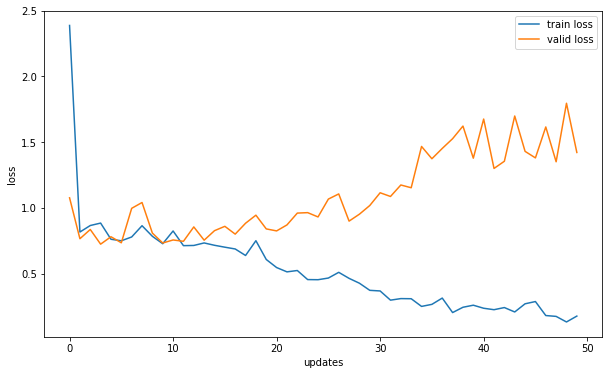

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

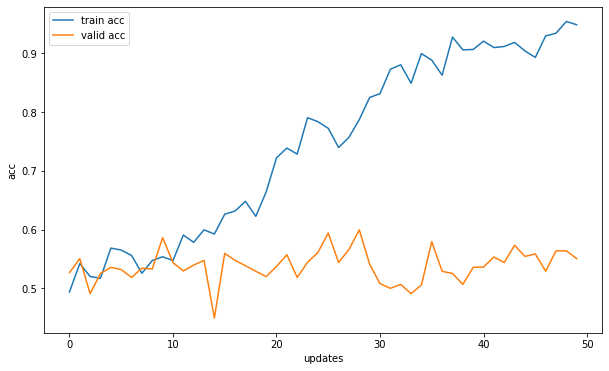

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [ ]:
model.load_state_dict(torch.load('tensor.pt'))
test_loss , test_acc = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.797 | Test Acc: 48.56%


# New Section

# New Section

In [ ]:
# Train the model
total_step = len(x_train)
loss_list = []
for epoch in range(num_epochs):
    ii = 0
    for i in range(16):
        xtrain = x_train[ii:ii+56]
        ytrain = y_train[ii:ii+56]
        outputs = model(xtrain)
        loss = criterion(outputs,ytrain )
        ii+=56
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 1 == 0:
            sys.stdout.write ('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        loss_list.append(loss)

Epoch [3/3], Step [16/896], Loss: 1.0421

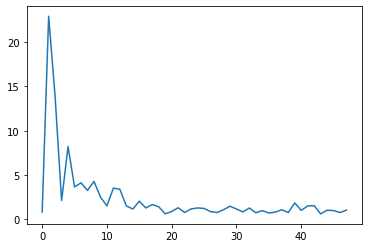

In [ ]:
plt.plot(loss_list);

In [ ]:
# Test the model
model.eval()  # eval mode will turn off the dropout; good to explicitly call when you test
all_labels = []
all_predicted = []
ii=0
with torch.no_grad():
    correct = 0
    total = 0
    for i in range(len(x_test)):
        outputs = model(x_test[ii:ii+1])
        _, predicted = torch.max(outputs.data, 1)
        total += y_test[ii:ii+1].size(0)
        correct += (predicted == y_test[ii:ii+1]).sum().item()
        all_labels.append(y_test.numpy())  #for plotting
        all_predicted.append(predicted.numpy())
        ii+=1

    print('Test Accuracy of the model : {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'models/cnn.ckpt')

Test Accuracy of the model : 53.125 %


# New Section

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl
train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

In [ ]:
for i in range (X_C5_C6.shape[0]):
    print(i+1)
    fig = plt.figure(figsize=(10, 20),dpi=80)
    gs = fig.add_gridspec(7, hspace=0)
    axs = gs.subplots(sharex=True, sharey=True)
    fig.suptitle('Sharing both axes')
    ax1=axs[0].specgram(X[i][0], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax2=axs[1].specgram(X[i][1], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax3=axs[2].specgram(X[i][2], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax4=axs[3].specgram(X[i][3], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax5=axs[4].specgram(X[i][4], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax6=axs[5].specgram(X[i][5], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax7=axs[6].specgram(X[i][6], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    ax7=axs[6].specgram(X[i][6], NFFT=128, Fs=160, noverlap=120,cmap='jet')
    axs[0].set_ylim(bottom=0, top=50)
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    axs[3].axis('off')
    axs[4].axis('off')
    axs[5].axis('off')
    axs[6].axis('off')
    fig.savefig('EEG_img/{}.png'.format(i), bbox_inches='tight')
print('Done !!!')

# Looking for sth in DATASET !!!

In [ ]:
!pip install mne
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from mne.time_frequency import psd_welch
from mne.decoding import cross_val_multiscore

In [ ]:
raw = mne.io.Raw(stft_data)

Opening raw data file [[[[-4.10205271e-01 -2.82937017e-01 -2.76540375e-01 ... -3.20857661e-01
    -2.87475184e-01 -2.75093116e-01]
   [ 1.75701586e-01  9.59826469e-02  1.02890833e-01 ...  5.79261860e-02
     9.20431194e-02  7.25384482e-02]
   [ 1.76798324e-01  1.84395433e-02  2.71723786e-02 ... -1.98032226e-02
     1.66405619e-02 -9.02627139e-03]
   ...
   [-3.48679236e-02 -1.27070304e-03  1.04447973e-03 ... -2.91039993e-04
    -7.33160824e-04 -9.67199983e-02]
   [ 1.07182949e-03 -1.26562957e-03  1.03963319e-03 ... -2.91288356e-04
    -7.30917496e-04 -1.04272603e-03]
   [ 3.58352525e-02 -1.26392581e-03  1.03800293e-03 ... -2.91266628e-04
    -7.30034217e-04  9.65720143e-02]]

  [[-5.17288302e-01 -1.60941184e-01 -1.41315084e-01 ... -1.76029367e-01
    -1.49476702e-01 -1.64884175e-01]
   [ 1.08150358e-01  3.60730685e-02  5.65040713e-02 ...  2.15530715e-02
     4.83418420e-02  1.15030362e-02]
   [ 3.85455228e-01 -5.54418784e-03  1.75594010e-02 ... -1.80255823e-02
     9.47677253e-03 -4.01

TypeError: ignored

In [ ]:
stft_data.type

AttributeError: ignored